In [ ]:
#Librerias a usar
import os
import pandas as pd
import multiprocessing as mp
import numpy as np
import time
import matplotlib.pyplot as plt

In [ ]:
#Para usar cuando se tienen los archivos en el drive
#from google.colab import drive
#drive.mount('/content/drive/')

In [ ]:
"""
Función para abrir un archivo CSV, calcular el promedio de la segunda columna(la que
contiene los datos tomados por los sensores)

Esta forma de introducir los argumentos de la función evita un error cuando se usa
pool.map() ya que en lugar de la tupla la entrada de args hace posible la iteración
"""
def procesar(args):
  archivo,carpeta = args
  ruta = os.path.join(carpeta, archivo)

  df = pd.read_csv(ruta)#Leer el archivo

  if df.shape[0] <= 1:
    return None
  #Obtener el nombre de la columna que contiene los datos de interés (segunda columna)
  columna_datos = df.columns[1]

  df = df[df[columna_datos] != -999]#Se elminan los valores atipicos

  df["Año"] = pd.to_datetime(df[df.columns[0]]).dt.year
  df["Mes"] = pd.to_datetime(df[df.columns[0]]).dt.month
  #Se calcula el promedio y se recupera el nombre de la columna
  promedio = (df.groupby(["Año", "Mes"])[columna_datos].mean()).reset_index()

  return promedio

In [ ]:
carpetas =["Humedad", "Temperatura", "Precipitacion"]#Lista de carpetas con los archivos CSV

#Lista de archivos en todas las carpetas
archivos = [(archivo, carpeta) for carpeta in carpetas for archivo in os.listdir(carpeta) if archivo.endswith(".csv")]

In [ ]:
#Programación en serie
inicio_serie = time.time()#Inicia a contabilizar el tiempo
promedio_serie = [procesar(archivo) for carpeta in carpetas for archivo in archivos]

fin_serie = time.time()#Finaliza la contabilización  del tiempo
tiempo_serie = fin_serie - inicio_serie#Tiempo total del cálculo en serie

In [ ]:
#Programación en paralelo
inicio_paralelo = time.time()#Inicia a contabilizar el tiempo
with mp.Pool(processes=mp.cpu_count()) as pool:

  promedio_paralelo = pool.map(procesar, archivos)
  promedio = [df for df in promedio_paralelo if df is not None]#eliminar los elementos vacíos

pool.close()

fin_paralelo = time.time()#Finaliza la contabilización  del tiempo

tiempo_paralelo = fin_paralelo - inicio_paralelo  # Tiempo total del cálculo en paralelo

In [ ]:
print(f"Tiempo total en serie: {tiempo_serie:.3f} s")
print(f"Tiempo total en paralelo: {tiempo_paralelo:.3f} s")

Tiempo total en serie: 113.631 s
Tiempo total en paralelo: 35.371 s


In [ ]:
#Tomar los elementos a manipular
temperatura = np.array([df for df in promedio if df.columns[2] == "Temperatura"])
Humedad = np.array([df for df in promedio if df.columns[2] == "Humedad"])
Precipitacion = np.array([df for df in promedio if df.columns[2] == "P1"])

In [ ]:
#Listas donde se guardaran las variables promediadas por año
temperatura_anual=[]
Humedad_anual=[]
Precipitacion_anual=[]

años=np.linspace(2014,2024,11)#años

for i in range(2014,2025):
  temperatura_anual.append(temperatura[np.where(temperatura == i)[0]][:,:,2].mean())
  Humedad_anual.append(Humedad[np.where(Humedad == i)[0]][:,:,2].mean())
  Precipitacion_anual.append(Precipitacion[np.where(Precipitacion == i)[0]][:,:,2].mean())

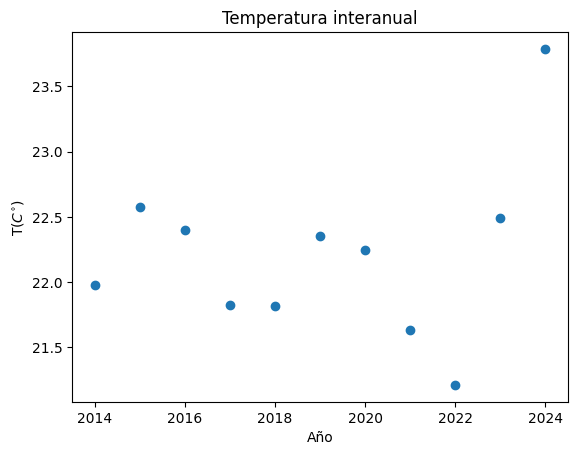

In [ ]:
plt.plot(años,temperatura_anual,"o")
plt.title("Temperatura interanual")
plt.xlabel("Año")
plt.ylabel("T($C^{\circ}$)")
plt.savefig("Temperatura_interanual.jpg")
plt.show()

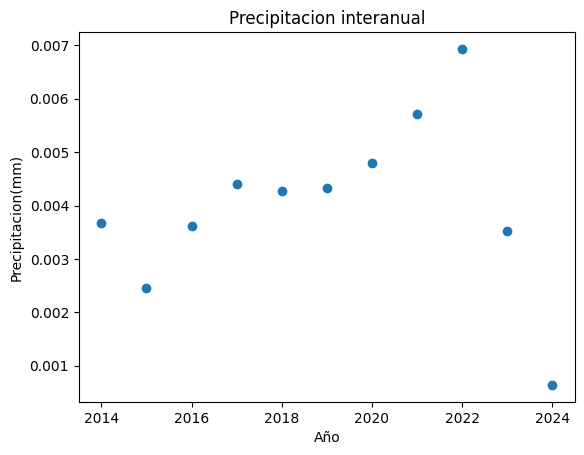

In [ ]:
plt.plot(años,Precipitacion_anual,"o")
plt.title("Precipitacion interanual")
plt.xlabel("Año")
plt.ylabel("Precipitacion(mm)")
plt.savefig("Precipitacion_interanual.jpg")
plt.show()

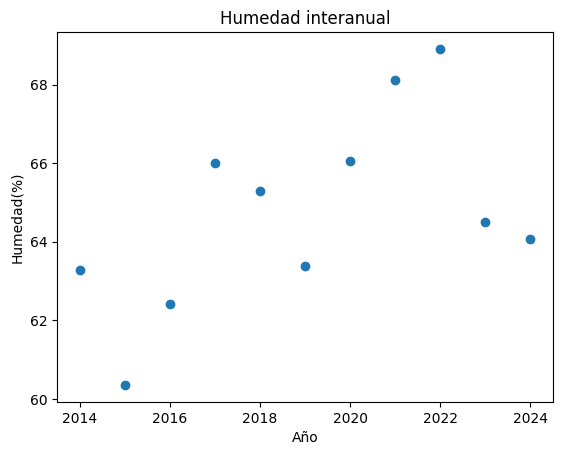

In [ ]:
plt.plot(años,Humedad_anual,"o")
plt.title("Humedad interanual")
plt.xlabel("Año")
plt.ylabel("Humedad(%)")
plt.savefig("Humedad_interanual.jpg")
plt.show()

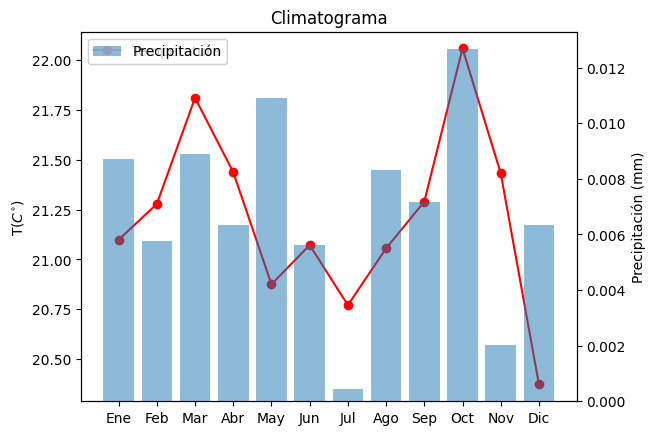

In [ ]:
meses = ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]

fig, ax1 = plt.subplots()

ax1.plot(meses, temperatura[np.where(temperatura == 2022)[0]][:,:,2], color="r", marker="o", label= "Temperatura")
ax1.set_ylabel("T($C^{\circ}$)")
plt.legend(loc="upper left")

#Se crea un segundo eje y para la precipitación
ax2 = ax1.twinx()
#Para las barras se necesita convertir la precipitación a un formato que sea permitido para ser graficado
ax2.bar(meses, Precipitacion[np.where(Precipitacion == 2022)[0]][:,:,2][:,0], alpha=0.5, label="Precipitación")
ax2.set_ylabel("Precipitación (mm)")
plt.legend()

plt.title("Climatograma")
plt.xlabel("Mes")
plt.savefig("Climatograma.jpg")
plt.show()